# 1. Charger les données et importer des bibliothèques

In [13]:
import pandas as pd
import pandas as pd
import numpy as np
# modèle
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt
films = pd.read_csv('./donnees/films_selectionnes.csv', sep="\t", low_memory=False)

In [14]:
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10474 entries, 0 to 10473
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  10474 non-null  bool   
 1   budget                 10474 non-null  int64  
 2   genres                 10474 non-null  object 
 3   id_tmdb                10474 non-null  int64  
 4   imdb_id                10474 non-null  object 
 5   original_language      10474 non-null  object 
 6   original_title         10474 non-null  object 
 7   original_title.1       10474 non-null  object 
 8   overview               10474 non-null  object 
 9   popularity             10474 non-null  float64
 10  poster_path            10474 non-null  object 
 11  production_countries   10474 non-null  object 
 12  release_date           10474 non-null  object 
 13  revenue                10474 non-null  int64  
 14  runtime                10474 non-null  int64  
 15  sp

Il existe des films avec le même titre. => au moment de la saisie du titre par l'utilisateur on lui propose de choisir le film (cela lui propose l'année, le directeur et le genre des films ayant le même titre)

# 2. Importer ce qu'il faut pour ne pas afficher les avertissements

In [15]:
#VA PERMETTRE DE SUPPRIMER LES AVERTISSEMENTS
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Savoir ce qu'on veut prédire, et à partir de quoi  :
On veut faire un clustering  / KNN: déterminer les k films les plus proches du film saisi par l'utilisateur

On déterminera k avec les métodes elbow et silhouette



##  - Supprimer les colonnes qu'on ne veut pas (dans l'entrainement)
Colonnes à garder :
* title'
* genres'
* original_language'
* popularity'
* runtime'
* vote_average'
* year' : attention à traiter comme une catégorie


Colonnes à suppprimer :
* adult'
* budget'
* id_tmdb'
* imdb_id'
* original_title'
* overview'
* poster_path'
* release_date'
* revenue'
* status'
* vote_count'
* directors'
* writers'
* spoken_languages'
* production_countries'

##  - Nettoyer les colonnes (NaN, doublons, format ...)
Pas de NaN dans films  
pas de doublons  

# 3. Déclarer X  et faire un `.reset_index(drop=True)` 


**Cible**  = un titre de film  
**Variables explicatives X** =
* title'
* genres' => toutes les colonnes crées plus haut
* original_language'
* popularity'
* runtime'
* vote_average'
* year' : attention à traiter comme une catégorie




In [16]:
X = films[['popularity','vote_average', 'genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']]
X

,popularity,vote_average,genre_Drama,genre_Horror,genre_Thriller,genre_Crime,genre_Animation,genre_Mystery,genre_Family,genre_Western,genre_Adventure,genre_Action,genre_Fantasy,genre_Comedy,genre_Music,genre_Romance,genre_War,genre_Documentary,genre_History,genre_Science Fiction
0,13.781,7.881,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,88.516,7.800,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
2,31.556,7.970,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,71.717,7.340,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
4,7.400,6.941,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469,0.994,6.600,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10470,1.378,7.000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10471,0.743,6.000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10472,0.824,6.000,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False



# 4. Séparer les variables numériques des variables catégorielles

# 5. Normalisation des valeurs numériques car clustering / KNN


# 6. Traitement des valeurs catégorielles / textes (transformation en nombre)
  - get_dummies en priorité (sinon factorize, mais à oublier)

# FONCTION encodage_X(X) qui fait les étapes 4-5-6 d'un coup
### Attention, ne pas oublier de Déclarer `X_encoded, SN = encodage_X(X)`

In [17]:
def encodage_X(X, type='standard'):
  index = X.index
  X_num = X[['popularity',  'vote_average']]
  X_cat = X[['genre_Drama', 'genre_Horror',
       'genre_Thriller', 'genre_Crime', 'genre_Animation', 'genre_Mystery',
       'genre_Family', 'genre_Western', 'genre_Adventure', 'genre_Action',
       'genre_Fantasy', 'genre_Comedy', 'genre_Music', 'genre_Romance',
       'genre_War', 'genre_Documentary', 'genre_History',
       'genre_Science Fiction']]
  

  if type == 'standard':
    from sklearn.preprocessing import StandardScaler
    SN = StandardScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)

  else:
    from sklearn.preprocessing import MinMaxScaler
    SN = MinMaxScaler()
    X_num_SN = pd.DataFrame(SN.fit_transform(X_num), columns=X_num.columns, index=index)

  X_cat_dummies = pd.get_dummies(X_cat)
  X_encoded = pd.concat([X_num_SN, X_cat_dummies], axis=1)

  return X_encoded, SN

In [18]:
X_encoded, SN = encodage_X(X,'normalisation')

In [19]:
import pickle

# Sauvegarder le modèle
with open('modeles/modele_SN_normalisation.pkl', 'wb') as f:
    pickle.dump(SN, f)

In [20]:
X_encoded

,popularity,vote_average,genre_Drama,genre_Horror,genre_Thriller,genre_Crime,genre_Animation,genre_Mystery,genre_Family,genre_Western,genre_Adventure,genre_Action,genre_Fantasy,genre_Comedy,genre_Music,genre_Romance,genre_War,genre_Documentary,genre_History,genre_Science Fiction
0,0.002826,0.575946,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.018847,0.559736,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
2,0.006636,0.593756,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,0.015245,0.467681,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False
4,0.001458,0.387833,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10469,0.000084,0.319592,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10470,0.000167,0.399640,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10471,0.000031,0.199520,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10472,0.000048,0.199520,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [21]:
SN

MinMaxScaler()

# 7. Déterminer des K possibles avec Elbow et Silhouette

In [22]:
def evaluate_k(X_encoded, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        X_encoded (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    for k in k_range:
        # Calcul des distances moyennes pour chaque k
        model = NearestNeighbors(n_neighbors=k)
        model.fit(X_encoded)
        distances, _ = model.kneighbors(X_encoded)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        # Nous utilisons KMeans pour créer des clusters et évaluer la qualité
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X_encoded)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(X_encoded, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores

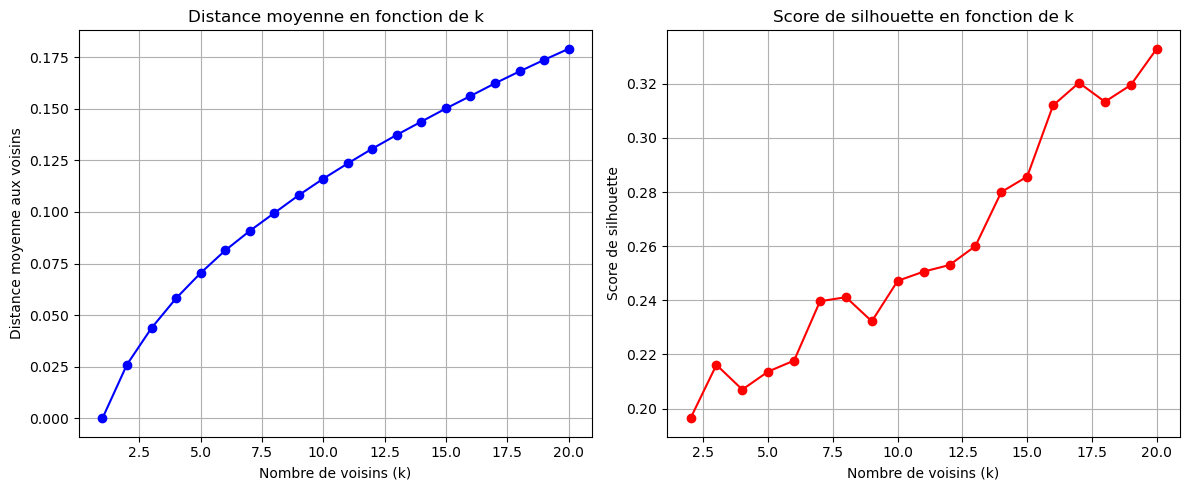

In [23]:
# Définition de la plage de k à tester
k_range = range(1, 21)  # Test des valeurs de k de 1 à 20

# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(X_encoded, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()

Ici le k idéal semble être entre 7 

# 8. Déclaration et entrainement du modèle
Mettre les paramètres ayant le meilleur score lors du GridSearch

In [24]:
from sklearn.neighbors import NearestNeighbors

# Création et ajustement du modèle NearestNeighbors
model = NearestNeighbors(n_neighbors=7, metric='euclidean')
model.fit(X_encoded)





NearestNeighbors(metric='euclidean', n_neighbors=7)

In [25]:
import pickle

# Sauvegarder le modèle
with open('modeles/modele_films_NN.pkl', 'wb') as f:
    pickle.dump(model, f)

# créer un fichier mon_modele.pkl que vous pouvez télécharger et mettre à l'endroit que vous voulez
# fichier réutilisable ailleurs

# vous importez vos fichiers csv pour vos données
# vous pouvez importer maintenant le fichier pkl pour votre modèle déjà entrainé

#ça vous pouvez le faire sur votre notebook

# 10. Récupération du titre de la cible + Recherche de films similaires + affichage 

Sur fichier recommandanations.py

